In [1]:
# Let's make a rotator distribution where we just pick a rotation angle to maintain each night. See if that results in something better

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic

In [29]:
runName = 'astro-lsst-01-2013'
opsdb = db.OpsimDatabase('astro-lsst-01_2013.db')
outDir = 'temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [34]:
bundleList = []

metric = metrics.RmsAngleMetric(col='rotSkyPos')
slicer = slicers.HealpixSlicer(nside=64)
sql = 'filter ="r"'

bundle = metricBundles.MetricBundle(metric, slicer, sql)
bundleList.append(bundle)
metric = metrics.FullRangeAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))

metric=metrics.MeanAngleMetric(col='rotSkyPos')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql))


Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Querying database SummaryAllProps with constraint filter ="r" for columns ['rotSkyPos', 'fieldRA', 'fieldDec']
Found 507717 visits
Running:  ['opsim_RmsAngle_rotSkyPos_r_HEAL', 'opsim_FullRangeAngle_rotSkyPos_r_HEAL', 'opsim_MeanAngle_rotSkyPos_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "filter ="r"" constraint now.
monopole: 45.682  dipole: lon: -32.6509, lat: -70.3532, amp: 14.6354
monopole: 224.877  dipole: lon: -40.0168, lat: -74.9162, amp: 49.778
monopole: 207.154  dipole: lon: -83.4704, lat: 82.5855, amp: 156.141
Plotting complete.


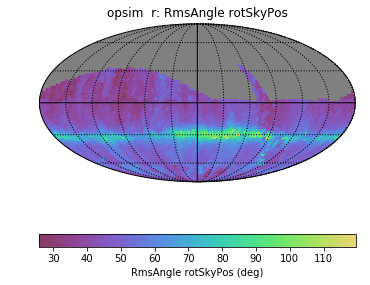

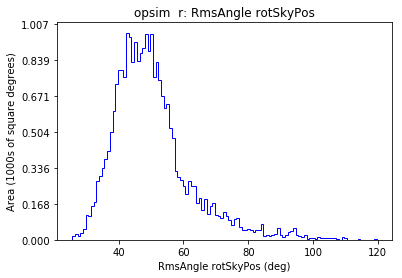

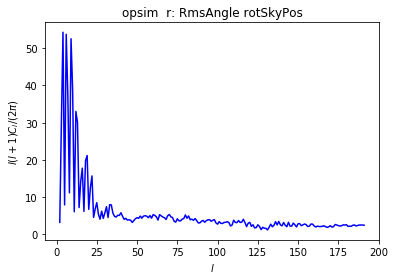

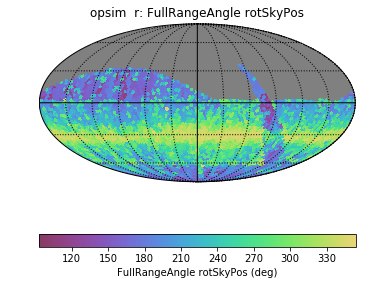

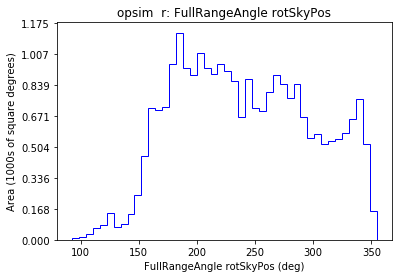

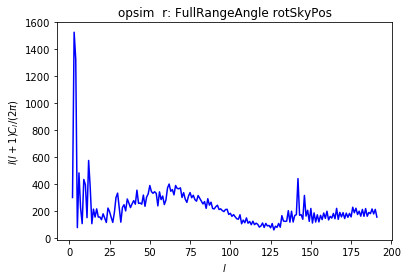

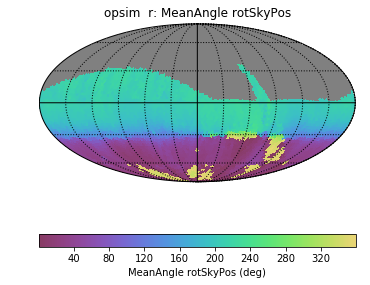

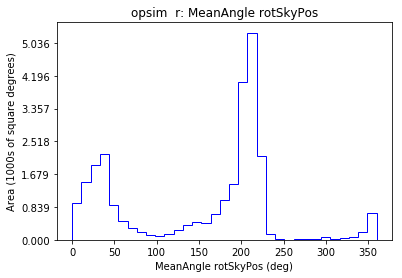

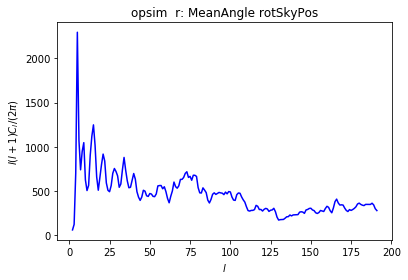

In [35]:
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
bgroup.plotAll(closefigs=False)

In [ ]:
# Now to make a new stacker that randomizes rotSkyPos per night, and then recalc the rotTelPos
class RandRotSkyPos(stackers.BaseStacker):
    def __init__(self, raCol='fieldRA', decCol='fieldDec', degrees=True, mjdCol='observationStartMJD',
                 lstCol='observationStartLST', rotTelPosCol='rotTelPos', 
                 nightCol='night', site='LSST'):
        self.lstCol = lstCol
        self.raCol = raCol
        self.decCol = decCol
        self.degrees = degrees
        self.mjdCol = mjdCol
        self.rotTelPosCol = rotTelPosCol
        self.nightCol = nightCol
        self.colsReq = [self.raCol, self.decCol, self.mjdCol, self.lstCol, self.rotTelPosCol, self.nightCol]
        self.colsAdded = ['rotTelPos', 'rotSkyPos', 'PA', 'HA']
        self.PA_stacker = stackers.ParallacticAngleStacker(raCol=raCol, decCol=decCol, degrees=degrees,
                                                          mjdCol=mjdCol, lstCol=lstCol, site=site)
        
    def _run(self, simData, cols_present=False):
        simData = self.PA_stacker._run(simData)
        n_nights = np.unique(simData[self.nightCol]).size
        
        